In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*
seaborn.set_context("talk")

filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])
k_id, temporal_freq = itemgetter("k_id", "w")(params["stimulus"])
angular_freq = temporal_freq * 2 * np.pi

A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
phase, damping, delay_g = itemgetter("phase", "damping", "delay")(params["ganglion"])

w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
tau_rg, delay_rg = itemgetter("tau", "delay")(params["relay"]["Krg"])

w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
tau_rig, delay_rig = itemgetter("tau", "delay")(params["relay"]["Krig"])

w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
tau_rig, delay_rig = itemgetter("tau", "delay")(params["relay"]["Krig"])

w_rc_ex, A_rc_ex, a_rc_ex = itemgetter("w", "A", "a")(params["relay"]["Krc_ex"])
tau_rc_ex, delay_rc_ex = itemgetter("tau", "delay")(params["relay"]["Krc_ex"])

w_rc_in, A_rc_in, a_rc_in = itemgetter("w", "A", "a")(params["relay"]["Krc_in"])
tau_rc_in, delay_rc_in = itemgetter("tau", "delay")(params["relay"]["Krc_in"])

w_rc_mix = itemgetter("w")(params["relay"]["Krc_mix"])
A_rc_mix_in, a_rc_mix_in = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_in"])
A_rc_mix_ex, a_rc_mix_ex = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_ex"])

delayed_in, synced, delayed_ex = itemgetter("delayed_in", "synced", "delayed_ex")(params["relay"]["Krc_mix"])

## Feedback inhibition

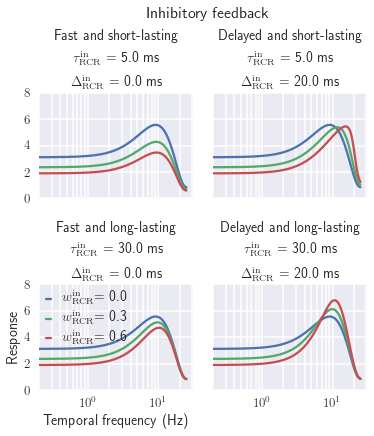

In [2]:
label = r"$w^\mathrm{in}_{\mathrm{RCR}}$"
tau_label = r"$\tau_\mathrm{RCR}^\mathrm{in}$"
delay_label = r"$\Delta_\mathrm{RCR}^\mathrm{in}$"
titles = ["Fast and short-lasting\n", "Delayed and short-lasting\n",
          "Fast and long-lasting\n", "Delayed and long-lasting\n"]


fig, axarr = plt.subplots(nrows=len(tau_rc_in), ncols=len(delay_rc_in), figsize=(5.5, 6.0), 
                          sharey="all", sharex="all")

plt.figtext(0.55, 0.999, "Inhibitory feedback", ha='center', va='center', fontsize=16)

k = -1
for i, tau in enumerate(tau_rc_in):
    for j, delay in enumerate(delay_rc_in):
        k += 1
        ax = axarr[i, j]
        for w in w_rc_in:
            network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                    A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                    phase=phase, damping=damping, delay_g=delay_g,
                                                    w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                    tau_rg=tau_rg, delay_rg=delay_rg,
                                                    w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                    tau_rig=tau_rig, delay_rig=delay_rig,
                                                    w_rc_in=w, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                                    tau_rc_in=tau, delay_rc_in=delay)
            [relay] = get_neuron("Relay", network)
            wavenumber = network.integrator.spatial_freqs[int(k_id)]
            tuning = relay.evaluate_irf_ft(angular_freq.rescale(1/pq.ms), wavenumber, wavenumber)
            tuning = np.absolute(tuning)
            
            title = titles[k]+ "{} = {} \n {} = {}".format(tau_label, round(tau, 1), 
                                                           delay_label, round(delay, 1))
            
            ax.plot(temporal_freq, tuning, label=label+"= {}".format(w))
            ax.set_xscale("log")
            ax.set_title(title, fontsize=14, linespacing=1.7)
            ax.grid(which="both", lw=1.5)

axarr[1, 0].set_xlabel("Temporal frequency (Hz)")
axarr[1, 0].set_ylabel("Response")
axarr[1, 0].set_ylim([0, 8])
axarr[1, 0].set_yticks([0, 2, 4, 6, 8])
axarr[1, 0].legend(fontsize=14, handlelength=0.3, labelspacing=0.3, borderpad=0.0)

plt.tight_layout()

## Feedback excitation

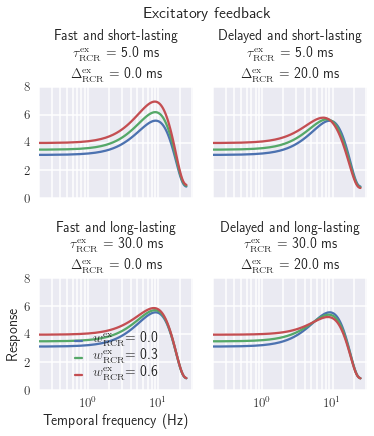

In [3]:
label = r"$w^\mathrm{ex}_{\mathrm{RCR}}$"
tau_label = r"$\tau_\mathrm{RCR}^\mathrm{ex}$"
delay_label = r"$\Delta_\mathrm{RCR}^\mathrm{ex}$"
titles = ["Fast and short-lasting\n", "Delayed and short-lasting\n",
          "Fast and long-lasting\n", "Delayed and long-lasting\n"]


fig, axarr = plt.subplots(nrows=len(tau_rc_in), ncols=len(delay_rc_in), figsize=(5.5, 6.0), 
                          sharey="all", sharex="all")

plt.figtext(0.55, 0.999, "Excitatory feedback", ha='center', va='center', fontsize=16)

k = -1
for i, tau in enumerate(tau_rc_ex):
    for j, delay in enumerate(delay_rc_ex):
        k += 1
        ax = axarr[i, j]
        for w in w_rc_in:
            network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                    A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                    phase=phase, damping=damping, delay_g=delay_g,
                                                    w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                    tau_rg=tau_rg, delay_rg=delay_rg,
                                                    w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                    tau_rig=tau_rig, delay_rig=delay_rig,
                                                    w_rc_ex=w, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                                    tau_rc_ex=tau, delay_rc_ex=delay)
            [relay] = get_neuron("Relay", network)
            wavenumber = network.integrator.spatial_freqs[int(k_id)]
            tuning = relay.evaluate_irf_ft(angular_freq.rescale(1/pq.ms), wavenumber, wavenumber)
            tuning = np.absolute(tuning)
            
            title = titles[k]+ "{} = {} \n {} = {}".format(tau_label, round(tau, 1), 
                                                           delay_label, round(delay, 1))
            
            ax.plot(temporal_freq, tuning, label=label+"= {}".format(w))
            ax.set_xscale("log")
            ax.set_title(title, fontsize=14, linespacing=1.7)
            ax.grid(which="both", lw=1.5)


axarr[1, 0].set_xlabel("Temporal frequency (Hz)")
axarr[1, 0].set_ylabel("Response")
axarr[1, 0].set_ylim([0, 8])
axarr[1, 0].legend(fontsize=14, handlelength=0.5, labelspacing=0.3, borderpad=0.0)

plt.tight_layout()

## Mixed excitatory and inhibitory feedback

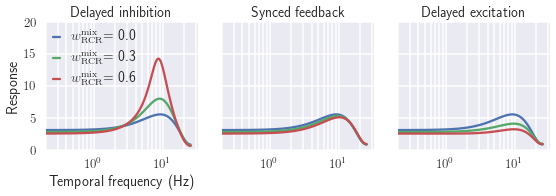

In [4]:
titles = ["Delayed inhibition", "Synced feedback", "Delayed excitation"]
tau_label = r"$\tau_\mathrm{RCR}^\mathrm{mix}$"
delay_label = r"$\Delta_\mathrm{RCR}^\mathrm{mix}$"
label = r"$w^\mathrm{mix}_{\mathrm{RCR}}$"

fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharey="all", sharex="all")

for ax, title, params in zip(axarr.flat, titles, [delayed_in, synced, delayed_ex]):
    for w in w_rc_mix:
        network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                                A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                                phase=phase, damping=damping, delay_g=delay_g,
                                                w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                                tau_rg=tau_rg, delay_rg=delay_rg,
                                                w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                                tau_rig=tau_rig, delay_rig=delay_rig,
                                                w_rc_ex=w, A_rc_ex=A_rc_mix_ex, a_rc_ex=a_rc_mix_ex,
                                                tau_rc_ex=params["tau_ex"], delay_rc_ex=params["delay_ex"],
                                                w_rc_in=w, A_rc_in=A_rc_mix_in, a_rc_in=a_rc_mix_in,
                                                tau_rc_in=params["tau_in"], delay_rc_in=params["delay_in"])
                                                
        [relay] = get_neuron("Relay", network)
        wavenumber = network.integrator.spatial_freqs[int(k_id)]
        tuning = relay.evaluate_irf_ft(angular_freq.rescale(1/pq.ms), wavenumber, wavenumber)
        tuning = np.absolute(tuning)

        ax.plot(temporal_freq, tuning, label=label+"= {}".format(w))
        ax.set_xscale("log")
        ax.set_title(title, fontsize=14, linespacing=1.7)
        ax.grid(which="both", lw=1.5)

axarr[0].set_xlabel("Temporal frequency (Hz)")
axarr[0].set_ylabel("Response")
axarr[0].set_ylim([0, 20])
axarr[0].legend(fontsize=14, handlelength=0.5, labelspacing=0.4, borderpad=0.0)

plt.tight_layout()